In [1]:
import torch
import random
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import os
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, UnidentifiedImageError
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import itertools
import torchvision
from torch.optim import SGD
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from scipy.spatial.distance import braycurtis, cityblock
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping






from pytorch_lightning.loggers import TensorBoardLogger


np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

NUM_EPOCHS=100

In [2]:
class PairDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform

        # Collect all image paths and labels
        self.image_paths = []
        self.labels = []
        self.character_labels = []

        # Save the names of the subject directories
        self.subjects = []

        # Create a mapping from subject names to labels
        self.label_mapping = {}
        
        for idx, subject in enumerate(os.listdir(root)):
            subject_path = os.path.join(root, subject)
            if os.path.isdir(subject_path):
                self.label_mapping[subject] = idx
                self.subjects.append(subject)
                for label in os.listdir(subject_path):
                    label_path = os.path.join(subject_path, label)
                    if os.path.isdir(label_path):
                        for image_name in os.listdir(label_path):
                            image_path = os.path.join(label_path, image_name)
                            # Check if the file is a valid image
                            try:
                                Image.open(image_path).verify()
                                self.image_paths.append(image_path)
                                self.labels.append(idx)
                                self.character_labels.append(label)
                            except (IOError, UnidentifiedImageError):
                                continue

        self.labels = np.array(self.labels)
        
        # Create a list of indices for each class and character
        self.class_char_to_indices = {}
        for idx in range(len(self.label_mapping)):
            self.class_char_to_indices[idx] = {}
            for char_label in set(self.character_labels):
                indices = [i for i in range(len(self.labels)) if self.labels[i] == idx and self.character_labels[i] == char_label]
                if indices:
                    self.class_char_to_indices[idx][char_label] = indices
        
        # Generate pairs
        self.generate_pairs()

    def generate_pairs(self):
        """Generates pairs, associating each element with a new element."""
        self.pair_labels = (np.random.rand(len(self.image_paths)) > 0.5).astype(int)
        self.paired_idx = []

        for i, l in enumerate(self.pair_labels):
            c1 = self.labels[i]
            char1 = self.character_labels[i]
            if l == 0:  # similar pair
                if char1 in self.class_char_to_indices[c1]:
                    j = np.random.choice(self.class_char_to_indices[c1][char1])
                else:
                    j = i
            else:  # dissimilar pair
                diff_class = np.random.choice(list(set(range(len(self.label_mapping))) - {c1}))
                diff_char = np.random.choice(list(self.class_char_to_indices[diff_class].keys()))
                j = np.random.choice(self.class_char_to_indices[diff_class][diff_char])
            self.paired_idx.append(j)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, i):
        im1_path = self.image_paths[i]
        im2_path = self.image_paths[self.paired_idx[i]]
        
        im1 = Image.open(im1_path).convert('L')
        im2 = Image.open(im2_path).convert('L')

        if self.transform:
            im1 = self.transform(im1)
            im2 = self.transform(im2)
        
        l = self.pair_labels[i]
        l1 = self.labels[i]
        l2 = self.labels[self.paired_idx[i]]
        char_label1 = self.character_labels[i]
        char_label2 = self.character_labels[self.paired_idx[i]]

        return im1, im2, l, l1, l2, char_label1, char_label2

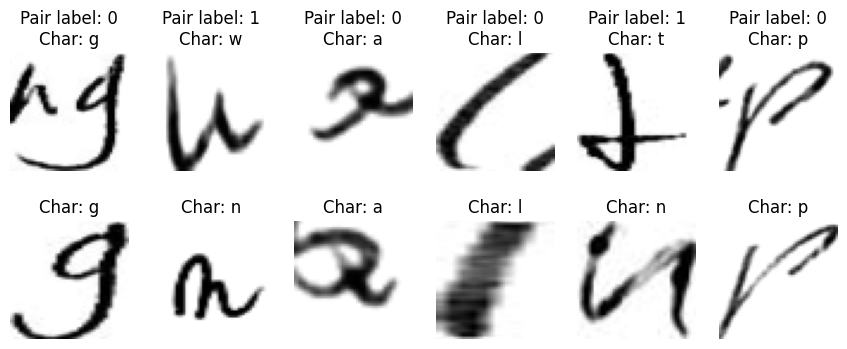

In [25]:
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np

pair_dataset = PairDataset(root='dataset', transform=transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor()
]))

plt.figure(figsize=(18, 4))
for ii, i in enumerate(np.random.choice(range(len(pair_dataset)), 6)):
    im1, im2, pair_label, _, _, char_label1, char_label2 = pair_dataset[i]
    plt.subplot(2, 10, ii + 1)
    plt.title(f'Pair label: {pair_label}\nChar: {char_label1}')
    plt.imshow(im1.squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(2, 10, ii + 11)
    plt.title(f'Char: {char_label2}')
    plt.imshow(im2.squeeze(), cmap='gray')
    plt.axis('off')

plt.show()

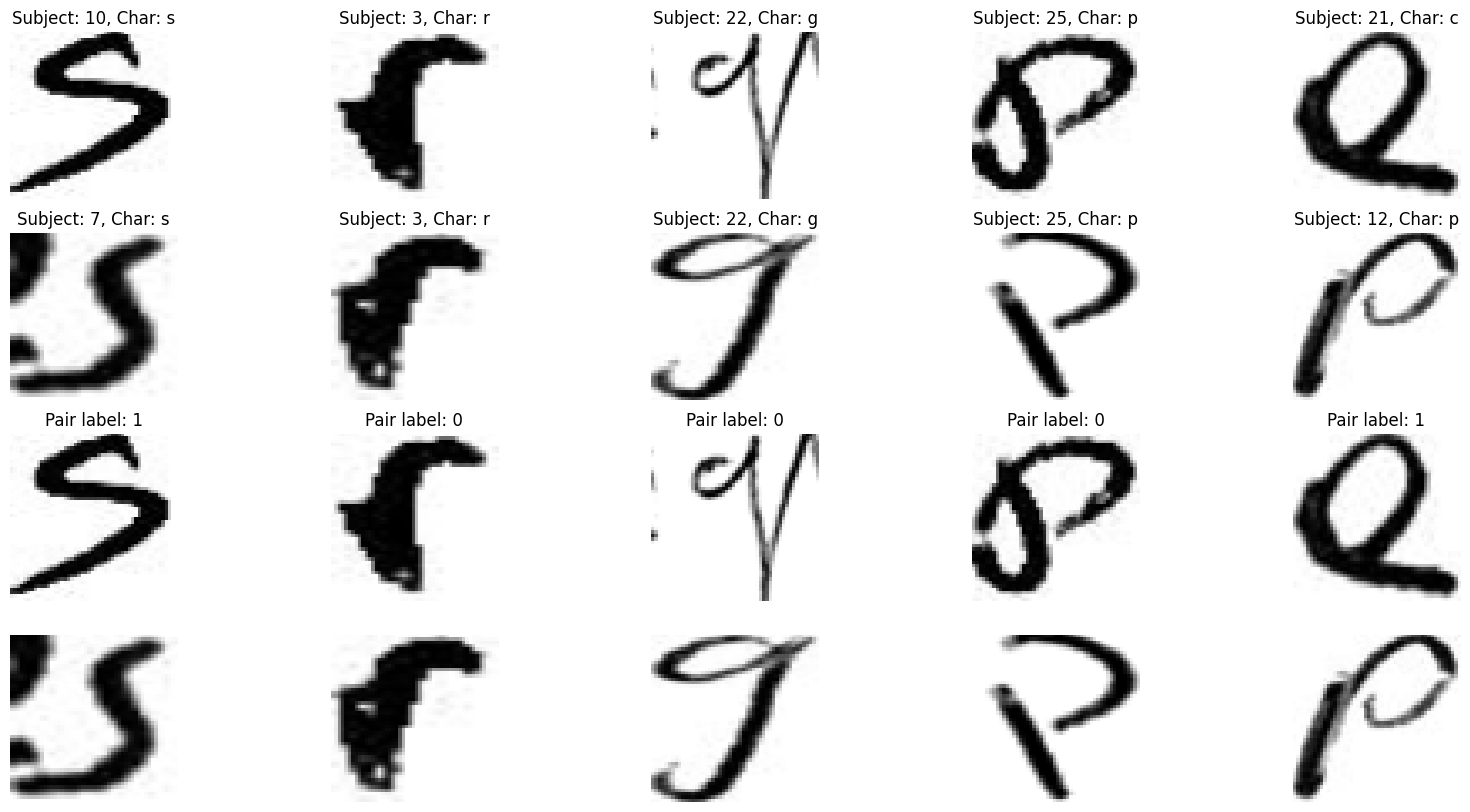

In [26]:
def verify_labels(dataset, num_samples=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        im1, im2, pair_label, label1, label2, char_label1, char_label2 = dataset[idx]

        plt.subplot(4, num_samples, i + 1)
        plt.title(f'Subject: {label1}, Char: {char_label1}')
        plt.imshow(im1.squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(4, num_samples, i + 1 + num_samples)
        plt.title(f'Subject: {label2}, Char: {char_label2}')
        plt.imshow(im2.squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(4, num_samples, i + 1 + 2 * num_samples)
        plt.title(f'Pair label: {pair_label}')
        plt.imshow(im1.squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(4, num_samples, i + 1 + 3 * num_samples)
        plt.imshow(im2.squeeze(), cmap='gray')
        plt.axis('off')
    
    plt.show()

# Verify labels in the pair_dataset
verify_labels(pair_dataset, num_samples=5)


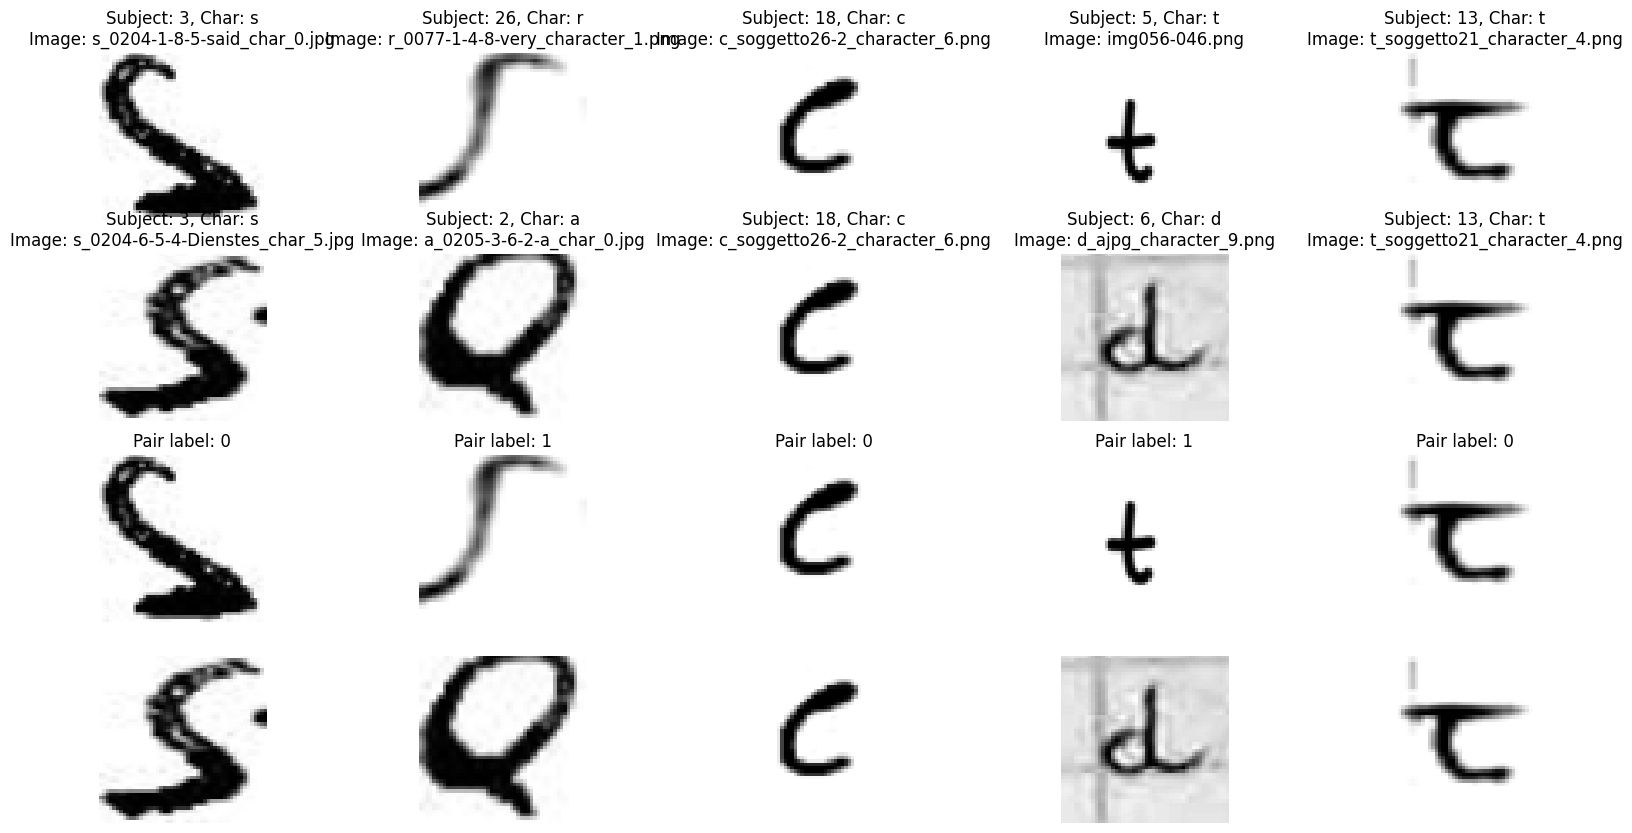

In [27]:
def verify_labels(dataset, num_samples=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        im1, im2, pair_label, label1, label2, char_label1, char_label2 = dataset[idx]
        im1_path = dataset.image_paths[idx]
        im2_path = dataset.image_paths[dataset.paired_idx[idx]]
        im1_name = os.path.basename(im1_path)
        im2_name = os.path.basename(im2_path)

        plt.subplot(4, num_samples, i + 1)
        plt.title(f'Subject: {label1}, Char: {char_label1}')
        plt.imshow(im1.squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(4, num_samples, i + 1 + num_samples)
        plt.title(f'Subject: {label2}, Char: {char_label2}')
        plt.imshow(im2.squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(4, num_samples, i + 1 + 2 * num_samples)
        plt.title(f'Pair label: {pair_label}')
        plt.imshow(im1.squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(4, num_samples, i + 1 + 3 * num_samples)
        plt.imshow(im2.squeeze(), cmap='gray')
        plt.axis('off')
    
    plt.show()

# Verify labels in the pair_dataset
verify_labels(pair_dataset, num_samples=5)

In [19]:
def count_pair_labels(dataset):
    count_label_0 = 0
    count_label_1 = 0
    
    for i in range(len(dataset)):
        _, _, pair_label, _, _, _, _ = dataset[i]
        if pair_label == 0:
            count_label_0 += 1
        else:
            count_label_1 += 1
    
    return count_label_0, count_label_1

# Count pairs in the full dataset
count_label_0, count_label_1 = count_pair_labels(full_dataset)

print(f'Number of pairs with label 0: {count_label_0}')
print(f'Number of pairs with label 1: {count_label_1}')

Number of pairs with label 0: 9120
Number of pairs with label 1: 9231


In [3]:
from torchvision.models import resnet18


class ResNetEmbedding(nn.Module):
    def __init__(self):
        super(ResNetEmbedding, self).__init__()
        self.resnet = resnet18(pretrained=True)
        
        # Modifica dell'ultimo livello completamente connesso
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 128)
    
    def forward(self, x):
        return self.resnet(x)

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, m=2):
        super(ContrastiveLoss, self).__init__()
        self.m = m

    def forward(self, phi_i, phi_j, l_ij):
        d = F.pairwise_distance(phi_i, phi_j)
        l = 0.5 * (1 - l_ij.float()) * torch.pow(d,2) + \
            0.5 * l_ij.float() * torch.pow(torch.clamp(self.m - d, min=0), 2)
        return l.mean()

class SiameseNetworkTask(pl.LightningModule):
    def __init__(self, 
                 embedding_net, # la rete di embedding
                 lr=0.01, # il learning rate
                 momentum=0.99, # momentum
                 margin=2 # margine per la loss
                ):
        super(SiameseNetworkTask, self).__init__()
        self.save_hyperparameters()
        self.embedding_net = embedding_net
        self.criterion = ContrastiveLoss(margin) # definiamo la loss
                    
    def forward(self, x):
        return self.embedding_net(x)
        
    def configure_optimizers(self):
        return SGD(self.embedding_net.parameters(), self.hparams.lr, momentum=self.hparams.momentum)
    
    def training_step(self, batch, batch_idx):
        # preleviamo gli elementi I_i e I_j e l'etichetta l_ij
        # scartiamo il resto (le etichette dei singoli elementi)
        I_i, I_j, l_ij, *_ = batch
        
        # l'implementazione della rete siamese è banale:
        # eseguiamo la embedding net sui due input
        phi_i = self.embedding_net(I_i)
        phi_j = self.embedding_net(I_j)

        # calcoliamo la loss
        l = self.criterion(phi_i, phi_j, l_ij)
        
        self.log('train/loss', l)
        return l
    
    def validation_step(self, batch, batch_idx):
        I_i, I_j, l_ij, *_ = batch
        phi_i = self.embedding_net(I_i)
        phi_j = self.embedding_net(I_j)
        l = self.criterion(phi_i, phi_j, l_ij)
        self.log('valid/loss', l)
        
        if batch_idx == 0:
            self.logger.experiment.add_embedding(phi_i, batch[3], I_i, global_step=self.global_step)
        return l

class ModelSaverCallback(pl.Callback):
    def __init__(self, save_path):
        super().__init__()
        self.save_path = save_path
        self.best_loss = float('inf')

    def on_validation_end(self, trainer, pl_module):
        current_loss = trainer.callback_metrics["valid/loss"].item()
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            torch.save(pl_module.state_dict(), self.save_path)
            print(f'Model saved with validation loss: {self.best_loss:.4f}')

resnet_embedding_net = ResNetEmbedding()

siamese_network_task = SiameseNetworkTask(resnet_embedding_net)

C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\utilities\parsing.py:208: Attribute 'embedding_net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['embedding_net'])`.


<h1>AlexNET</h1>

In [3]:
from torchvision.models import alexnet


class AlexNetEmbedding(nn.Module):
    def __init__(self):
        super(AlexNetEmbedding, self).__init__()
        self.alexnet = alexnet(pretrained=True)
        
        # Modifica dell'ultimo livello completamente connesso
        num_ftrs = self.alexnet.classifier[6].in_features
        self.alexnet.classifier[6] = nn.Linear(num_ftrs, 128)
    
    def forward(self, x):
        return self.alexnet(x)

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, m=2):
        super(ContrastiveLoss, self).__init__()
        self.m = m

    def forward(self, phi_i, phi_j, l_ij):
        d = F.pairwise_distance(phi_i, phi_j)
        l = 0.5 * (1 - l_ij.float()) * torch.pow(d, 2) + \
            0.5 * l_ij.float() * torch.pow(torch.clamp(self.m - d, min=0), 2)
        return l.mean()

class SiameseNetworkTask(pl.LightningModule):
    def __init__(self, 
                 embedding_net, # la rete di embedding
                 lr=0.01, # il learning rate
                 momentum=0.99, # momentum
                 margin=2 # margine per la loss
                ):
        super(SiameseNetworkTask, self).__init__()
        self.save_hyperparameters()
        self.embedding_net = embedding_net
        self.criterion = ContrastiveLoss(margin) # definiamo la loss
                    
    def forward(self, x):
        return self.embedding_net(x)
        
    def configure_optimizers(self):
        return SGD(self.embedding_net.parameters(), self.hparams.lr, momentum=self.hparams.momentum)
    
    def training_step(self, batch, batch_idx):
        # preleviamo gli elementi I_i e I_j e l'etichetta l_ij
        # scartiamo il resto (le etichette dei singoli elementi)
        I_i, I_j, l_ij, *_ = batch
        
        # l'implementazione della rete siamese è banale:
        # eseguiamo la embedding net sui due input
        phi_i = self.embedding_net(I_i)
        phi_j = self.embedding_net(I_j)

        # calcoliamo la loss
        l = self.criterion(phi_i, phi_j, l_ij)
        
        self.log('train/loss', l)
        return l
    
    def validation_step(self, batch, batch_idx):
        I_i, I_j, l_ij, *_ = batch
        phi_i = self.embedding_net(I_i)
        phi_j = self.embedding_net(I_j)
        l = self.criterion(phi_i, phi_j, l_ij)
        self.log('valid/loss', l)
        
        if batch_idx == 0:
            self.logger.experiment.add_embedding(phi_i, batch[3], I_i, global_step=self.global_step)

alexnet_embedding_net = AlexNetEmbedding()

siamese_network_task = SiameseNetworkTask(alexnet_embedding_net)


C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\utilities\parsing.py:208: Attribute 'embedding_net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['embedding_net'])`.


In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

# Define the transformation without normalization
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7838, 0.7838, 0.7838], std=[0.3301, 0.3301, 0.3301])
])

# Create the full dataset with normalization
full_dataset = PairDataset(root='dataset', transform=transform)

# Split the dataset into training and testing
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

early_stop_callback = EarlyStopping(
    monitor='valid/loss',
    min_delta=0.001,
    patience=20,
    verbose=True,
    mode='min'
)

model_saver_callback = ModelSaverCallback(save_path='models/siamese_SubjectModel3.pth')



In [5]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("logs", name="siamese_SubjectResnet3")

trainer = pl.Trainer(
    logger=logger,
    max_epochs=100,
    callbacks=[early_stop_callback, model_saver_callback],
    enable_progress_bar=True,
    log_every_n_steps=20,
    accelerator="gpu",
    devices=1
)

trainer.fit(siamese_network_task, train_loader, test_loader)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: logs\siamese_SubjectResnet3
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type            | Params | Mode 
----------------------------------------------------------
0 | embedding_net | ResNetEmbedding | 11.2 M | train
1 | criterion     | ContrastiveLoss | 0      | train
----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.969    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Model saved with validation loss: 3.6243


C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 23. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Metric valid/loss improved. New best score: 0.189


Model saved with validation loss: 0.1894


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid/loss improved by 0.026 >= min_delta = 0.001. New best score: 0.164


Model saved with validation loss: 0.1636


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid/loss improved by 0.016 >= min_delta = 0.001. New best score: 0.147


Model saved with validation loss: 0.1471


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid/loss improved by 0.004 >= min_delta = 0.001. New best score: 0.143


Model saved with validation loss: 0.1434


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.142


Model saved with validation loss: 0.1420


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid/loss improved by 0.006 >= min_delta = 0.001. New best score: 0.136


Model saved with validation loss: 0.1359


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid/loss improved by 0.004 >= min_delta = 0.001. New best score: 0.131


Model saved with validation loss: 0.1314


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid/loss improved by 0.003 >= min_delta = 0.001. New best score: 0.128


Model saved with validation loss: 0.1281


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid/loss improved by 0.003 >= min_delta = 0.001. New best score: 0.125


Model saved with validation loss: 0.1254


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.124


Model saved with validation loss: 0.1242


Validation: |          | 0/? [00:00<?, ?it/s]

Model saved with validation loss: 0.1233


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid/loss improved by 0.005 >= min_delta = 0.001. New best score: 0.119


Model saved with validation loss: 0.1191


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid/loss improved by 0.003 >= min_delta = 0.001. New best score: 0.116


Model saved with validation loss: 0.1165


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid/loss improved by 0.004 >= min_delta = 0.001. New best score: 0.113


Model saved with validation loss: 0.1125


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.111


Model saved with validation loss: 0.1111


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid/loss improved by 0.004 >= min_delta = 0.001. New best score: 0.108


Model saved with validation loss: 0.1076


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Model saved with validation loss: 0.1070


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid/loss improved by 0.002 >= min_delta = 0.001. New best score: 0.105


Model saved with validation loss: 0.1052


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Model saved with validation loss: 0.1049


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Model saved with validation loss: 0.1045


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid/loss improved by 0.003 >= min_delta = 0.001. New best score: 0.102


Model saved with validation loss: 0.1018


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Model saved with validation loss: 0.1010


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 0.001. New best score: 0.101


Model saved with validation loss: 0.1005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Model saved with validation loss: 0.1005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric valid/loss did not improve in the last 20 records. Best score: 0.101. Signaling Trainer to stop.


In [7]:
# Dopo l'addestramento, puoi salvare lo stato del modello

torch.save(siamese_network_task.state_dict(), 'models/siamese_SubjectModel4.pth')


In [12]:
resnet_embedding_net = ResNetEmbedding()
loaded_model = SiameseNetworkTask(resnet_embedding_net)

# Caricare lo stato del modello
loaded_model.load_state_dict(torch.load('models/siamese_SubjectModel4.pth'))

C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\utilities\parsing.py:208: Attribute 'embedding_net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['embedding_net'])`.


<All keys matched successfully>

In [12]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                images.append(img_path)
                labels.append(label)
    return images, labels

def calculate_class_means(image_paths, labels, model, device):
    class_vectors = {}
    class_counts = {}
    
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        for img_path, label in zip(image_paths, labels):
            image = Image.open(img_path).convert('L')
            image = transform(image).unsqueeze(0).to(device)
            feature_vector = model(image).cpu().numpy().flatten()
            
            if label not in class_vectors:
                class_vectors[label] = feature_vector
                class_counts[label] = 1
            else:
                class_vectors[label] += feature_vector
                class_counts[label] += 1
    
    class_means = {label: class_vectors[label] / class_counts[label] for label in class_vectors}
    return class_means

def calculate_distances(class_means1, class_means2, all_labels):
    distances_euclidean = {}
    distances_manhattan = {}
    distances_braycurtis = {}
    
    for label in all_labels:
        if label in class_means1 and label in class_means2:
            distance_euclidean = np.linalg.norm(class_means1[label] - class_means2[label])
            distance_manhattan = cityblock(class_means1[label], class_means2[label])
            distance_braycurtis = braycurtis(class_means1[label], class_means2[label])
            
            distances_euclidean[label] = distance_euclidean
            distances_manhattan[label] = distance_manhattan
            distances_braycurtis[label] = distance_braycurtis
    
    return distances_euclidean, distances_manhattan, distances_braycurtis

def normalize_distances(distances):
    valid_distances = [dist for dist in distances.values() if not np.isnan(dist)]
    min_distance = min(valid_distances)
    max_distance = max(valid_distances)
    
    normalized_distances = {label: 1 + 9 * ((dist - min_distance) / (max_distance - min_distance))
                            if not np.isnan(dist) else np.nan for label, dist in distances.items()}
    
    return normalized_distances, min_distance, max_distance

def calculate_overall_distance(distances, min_distance, max_distance):
    valid_distances = [dist for dist in distances.values() if not np.isnan(dist)]
    overall_distance = np.mean(valid_distances)
    
    normalized_overall_distance = 1 + 9 * ((overall_distance - min_distance) / (max_distance - min_distance))
    return normalized_overall_distance

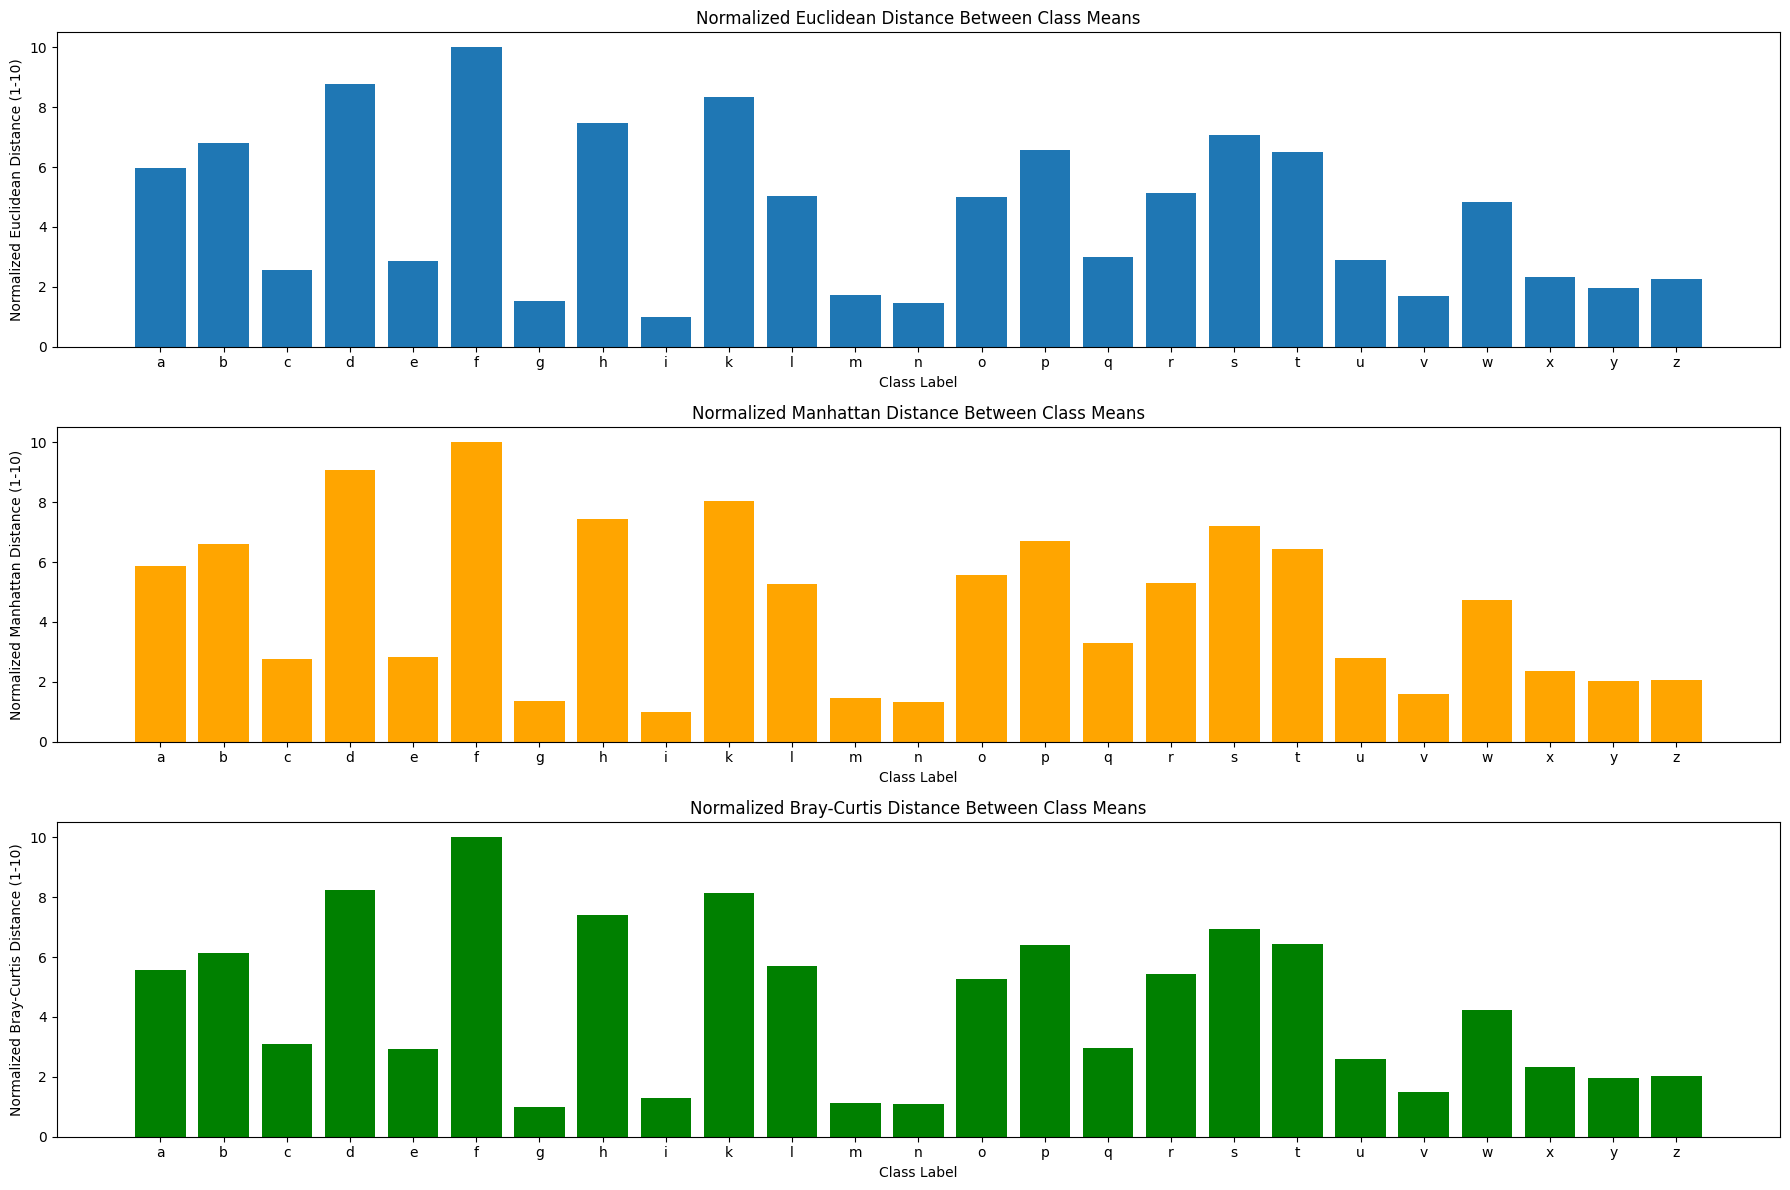

Overall Euclidean Distance (Normalized): 4.51
Overall Manhattan Distance (Normalized): 4.52
Overall Bray-Curtis Distance (Normalized): 4.39


In [34]:

# Load images and labels from two subjects
subject1_folder = r'C:\Users\orazi\OneDrive\Desktop\tesi\soggetti2\0002'
subject2_folder = r'C:\Users\orazi\OneDrive\Desktop\tesi\soggetti2\0003'

subject1_images, subject1_labels = load_images_from_folder(subject1_folder)
subject2_images, subject2_labels = load_images_from_folder(subject2_folder)

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_embedding_net = ResNetEmbedding()

# Calculate class means for both subjects
class_means1 = calculate_class_means(subject1_images, subject1_labels, loaded_model, device)
class_means2 = calculate_class_means(subject2_images, subject2_labels, loaded_model, device)

# List of all labels from 'a' to 'z' excluding 'j'
all_labels = [chr(i) for i in range(97, 123) if chr(i) != 'j']

# Calculate distances between class means
distances_euclidean, distances_manhattan, distances_braycurtis = calculate_distances(class_means1, class_means2, all_labels)

# Normalize distances to a scale from 1 to 10
normalized_distances_euclidean, min_distance_euclidean, max_distance_euclidean = normalize_distances(distances_euclidean)
normalized_distances_manhattan, min_distance_manhattan, max_distance_manhattan = normalize_distances(distances_manhattan)
normalized_distances_braycurtis, min_distance_braycurtis, max_distance_braycurtis = normalize_distances(distances_braycurtis)

# Calculate overall distance
normalized_overall_distance_euclidean = calculate_overall_distance(distances_euclidean, min_distance_euclidean, max_distance_euclidean)
normalized_overall_distance_manhattan = calculate_overall_distance(distances_manhattan, min_distance_manhattan, max_distance_manhattan)
normalized_overall_distance_braycurtis = calculate_overall_distance(distances_braycurtis, min_distance_braycurtis, max_distance_braycurtis)

# Plot normalized distances
labels = sorted(normalized_distances_euclidean.keys())

plt.figure(figsize=(18, 12))

plt.subplot(3, 1, 1)
distances_euclidean = [normalized_distances_euclidean[label] for label in labels]
plt.bar(labels, distances_euclidean)
plt.xlabel('Class Label')
plt.ylabel('Normalized Euclidean Distance (1-10)')
plt.title('Normalized Euclidean Distance Between Class Means')

plt.subplot(3, 1, 2)
distances_manhattan = [normalized_distances_manhattan[label] for label in labels]
plt.bar(labels, distances_manhattan, color='orange')
plt.xlabel('Class Label')
plt.ylabel('Normalized Manhattan Distance (1-10)')
plt.title('Normalized Manhattan Distance Between Class Means')

plt.subplot(3, 1, 3)
distances_braycurtis = [normalized_distances_braycurtis[label] for label in labels]
plt.bar(labels, distances_braycurtis, color='green')
plt.xlabel('Class Label')
plt.ylabel('Normalized Bray-Curtis Distance (1-10)')
plt.title('Normalized Bray-Curtis Distance Between Class Means')

plt.tight_layout()
plt.show()

# Print overall distance
print(f"Overall Euclidean Distance (Normalized): {normalized_overall_distance_euclidean:.2f}")
print(f"Overall Manhattan Distance (Normalized): {normalized_overall_distance_manhattan:.2f}")
print(f"Overall Bray-Curtis Distance (Normalized): {normalized_overall_distance_braycurtis:.2f}")

In [13]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.7838, 0.7838, 0.7838], std=[0.3301, 0.3301, 0.3301])
])

# Custom Contrastive Loss with a maximum cap of 2
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, m=2):
        super(ContrastiveLoss, self).__init__()
        self.m = m

    def forward(self, phi_i, phi_j, l_ij):
        d = F.pairwise_distance(phi_i, phi_j)
        l = 0.5 * (1 - l_ij.float()) * torch.pow(d, 2) + \
            0.5 * l_ij.float() * torch.pow(torch.clamp(self.m - d, min=0), 2)
        return torch.clamp(l.mean(), max=self.m)  # Cap the loss at m (2 in this case)

def load_images_from_folder(folder):
    images = []
    labels = []
    valid_image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')  # Aggiungi altri formati se necessario

    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                if img_name.lower().endswith(valid_image_extensions):
                    img_path = os.path.join(label_path, img_name)
                    try:
                        Image.open(img_path).verify()  # Verifica che il file sia un'immagine valida
                        images.append(img_path)
                        labels.append(label)
                    except (IOError, UnidentifiedImageError):
                        continue
    return images, labels

def calculate_class_means(image_paths, labels, model, device):
    class_vectors = {}
    class_counts = {}
    
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        for img_path, label in zip(image_paths, labels):
            image = Image.open(img_path).convert('L')
            image = transform(image).unsqueeze(0).to(device)
            feature_vector = model(image).cpu().numpy().flatten()
            
            if label not in class_vectors:
                class_vectors[label] = feature_vector
                class_counts[label] = 1
            else:
                class_vectors[label] += feature_vector
                class_counts[label] += 1
    
    class_means = {label: class_vectors[label] / class_counts[label] for label in class_vectors}
    return class_means

def calculate_contrastive_distances(class_means1, class_means2, model, device):
    contrastive_loss = ContrastiveLoss()
    distances = {}
    
    for label in class_means1:
        if label in class_means2:
            vec1 = torch.tensor(class_means1[label], device=device).unsqueeze(0)
            vec2 = torch.tensor(class_means2[label], device=device).unsqueeze(0)
            dist = contrastive_loss(vec1, vec2, torch.tensor([0], device=device)).item()
            distances[label] = dist
    
    return distances


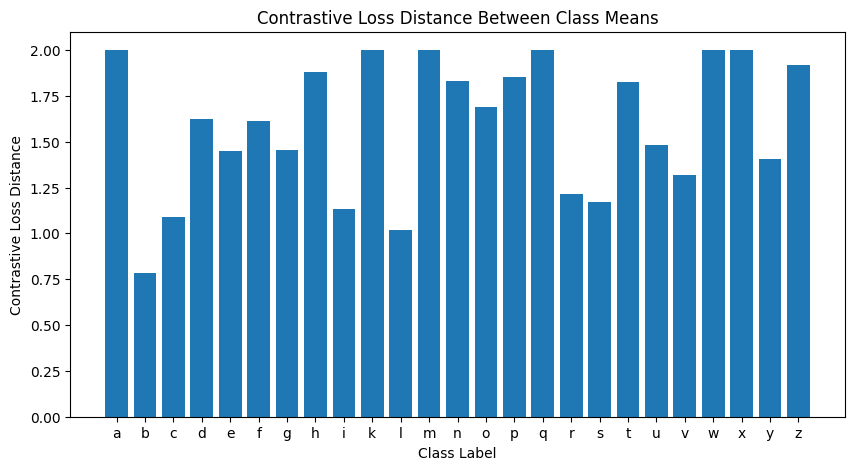

Overall Contrastive Loss Distance: 1.59


In [8]:

# Load images and labels from two subjects
# Load images and labels from two subjects
subject1_folder = 'dataset/soggetto1'
subject2_folder = 'dataset/soggetto4'

subject1_images, subject1_labels = load_images_from_folder(subject1_folder)
subject2_images, subject2_labels = load_images_from_folder(subject2_folder)

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Calculate class means for both subjects
class_means1 = calculate_class_means(subject1_images, subject1_labels, loaded_model, device)
class_means2 = calculate_class_means(subject2_images, subject2_labels, loaded_model, device)

# Calculate Contrastive Loss distances between class means
distances = calculate_contrastive_distances(class_means1, class_means2, loaded_model, device)

# Plot distances
labels = sorted(distances.keys())

plt.figure(figsize=(10, 5))
distances_list = [distances[label] for label in labels]
plt.bar(labels, distances_list)
plt.xlabel('Class Label')
plt.ylabel('Contrastive Loss Distance')
plt.title('Contrastive Loss Distance Between Class Means')
plt.show()

# Print overall distance
overall_distance = np.mean([dist for dist in distances.values() if not np.isnan(dist)])
print(f"Overall Contrastive Loss Distance: {overall_distance:.2f}") 

In [14]:
import pandas as pd

# Funzione per calcolare la matrice delle distanze
def calculate_distance_matrix(subject_folders, model, device):
    subject_means = {}
    
    for folder in subject_folders:
        images, labels = load_images_from_folder(folder)
        subject_means[folder] = calculate_class_means(images, labels, model, device)
    
    subject_names = list(subject_means.keys())
    num_subjects = len(subject_names)
    
    distance_matrix = np.zeros((num_subjects, num_subjects))
    
    for i in range(num_subjects):
        for j in range(num_subjects):
            if i != j:
                distances = calculate_contrastive_distances(subject_means[subject_names[i]], subject_means[subject_names[j]], model, device)
                overall_distance = np.mean([dist for dist in distances.values() if not np.isnan(dist)])
                distance_matrix[i, j] = overall_distance
            else:
                distance_matrix[i, j] = 0
    
    return distance_matrix, subject_names

# Percorsi delle cartelle dei soggetti
dataset_folder = 'dataset'
subject_folders = [os.path.join(dataset_folder, folder) for folder in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, folder))]

# Calcola la matrice delle distanze
distance_matrix, subject_names = calculate_distance_matrix(subject_folders, loaded_model, device)

# Crea il dataset con etichette binarie
data = []
threshold = 0.5 #più è vicino al 2 più sono distanti più è vicino allo 0 più sono simili

for i, subject1 in enumerate(subject_names):
    for j, subject2 in enumerate(subject_names):
        if i != j:
            label = 'Different' if distance_matrix[i, j] > threshold else 'Similar'
            data.append((subject1, subject2, distance_matrix[i, j], label))

df = pd.DataFrame(data, columns=['Subject1', 'Subject2', 'Distance', 'Label'])



In [15]:
# Salva il dataset in un file CSV
df.to_csv('subject_similarity_dataset2.csv', index=False)

In [16]:
df = pd.read_csv('subject_similarity_dataset2.csv')
label_counts = df['Label'].value_counts()
label_counts

Label
Different    558
Similar      144
Name: count, dtype: int64

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Carica il dataset
df = pd.read_csv('subject_similarity_dataset.csv')

# Codifica le etichette binarie ("Yes" e "No") in valori numerici
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

# Prepara le feature e il target
X = df[['Distance']]
y = df['Label']

# Dividi i dati in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inizializza e addestra l'SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Fai previsioni sul test set
y_pred = svm_model.predict(X_test)

# Valuta le prestazioni del modello
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99       102
           1       0.93      1.00      0.96        39

    accuracy                           0.98       141
   macro avg       0.96      0.99      0.97       141
weighted avg       0.98      0.98      0.98       141

Confusion Matrix:
 [[99  3]
 [ 0 39]]


In [46]:
# Funzione per calcolare la distanza tra due soggetti
def calculate_distance_between_subjects(subject1_folder, subject2_folder, model, device):
    # Carica le immagini e le etichette per entrambi i soggetti
    subject1_images, subject1_labels = load_images_from_folder(subject1_folder)
    subject2_images, subject2_labels = load_images_from_folder(subject2_folder)
    
    # Calcola le medie delle classi per entrambi i soggetti
    class_means1 = calculate_class_means(subject1_images, subject1_labels, model, device)
    class_means2 = calculate_class_means(subject2_images, subject2_labels, model, device)
    
    # Calcola la distanza di Contrastive Loss tra i due soggetti
    distances = calculate_contrastive_distances(class_means1, class_means2, model, device)
    
    # Calcola la distanza complessiva
    overall_distance = np.mean([dist for dist in distances.values() if not np.isnan(dist)])
    
    return overall_distance

# Funzione per fare la previsione
def predict_similarity(subject1_folder, subject2_folder, model, svm_model, device):
    distance = calculate_distance_between_subjects(subject1_folder, subject2_folder, model, device)
    prediction = svm_model.predict([[distance]])
    label = label_encoder.inverse_transform(prediction)[0]
    return label, distance

# Percorsi delle cartelle dei due soggetti
subject1_folder = r'C:\Users\orazi\OneDrive\Desktop\tesi\datiT\a'
subject2_folder = r'C:\Users\orazi\OneDrive\Desktop\tesi\datiT\b'

# Fai una previsione sulla similarità
label, distance = predict_similarity(subject1_folder, subject2_folder, loaded_model, svm_model, device)

print(f"La previsione è che i soggetti siano: {label}")
print(f"Overall Distance: {distance:.2f}")

La previsione è che i soggetti siano: Different
Overall Distance: 1.46


C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
